In [1]:
import numpy as np
import datetime
import statsmodels.api as sm
from statsmodels.sandbox.tools.tools_pca import pca
from scipy import stats
from statsmodels.regression.rolling import RollingOLS
import random
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  
import os.path  
import sys  
import backtrader as bt
from backtrader import Indicator
import os
import math
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy

import pandas as pd

from sklearn.decomposition import PCA
    

# Backtrader: Strategy Indicators

In [2]:
class Arbitrage:
    def __init__(self, window, pca_window, n_pc, req_k):
        self.window = window
        self.pca_window = pca_window
        self.n_pc = n_pc
        self.req_k = req_k
        self.all_rets = pd.DataFrame()
        self.all_prices = pd.DataFrame()
        
    def run_pca(self, rets):
        std = rets.std(0)
        std_rets = (rets - rets.mean(0)) / std
        cov = std_rets.cov()
        pca = PCA(n_components = self.n_pc)
        pca.fit(std_rets)
        norm_wgt = pd.DataFrame(pca.components_, columns=rets.columns,index=['PC{}'.format(i + 1) for i in range(self.n_pc)]).T
        norm_wgt = norm_wgt.div(std, axis=0)
        norm_wgt = norm_wgt / norm_wgt.sum()
        pc_rets = pd.DataFrame(np.dot(rets, norm_wgt), index=rets.index, columns=['PC{}'.format(i+1) for i in range(self.n_pc)])
        return norm_wgt, pc_rets
    
    def run_ols(self, rets, pc_rets):
        tickers = rets.columns
        pc_rets= sm.add_constant(pc_rets)
        result = pd.DataFrame(index=tickers, columns = pc_rets.columns)
        for t in tickers:
            res = sm.OLS(rets[t], pc_rets).fit()
            result.loc[t] = res.params
        return result
    
    def cal_score(self, rets, pc_rets , ols_result):
        tickers = rets.columns
        
        m = pd.Series(index=tickers, dtype='float')
        sigma_eq = pd.Series(index=tickers, dtype='float')
        
        for t in tickers:
            dX = rets[t] - np.dot(sm.add_constant(pc_rets), ols_result.loc[t])
            X = dX.astype('float').cumsum()
            b = X.autocorr()
            if -math.log(b) * 252 > self.req_k:
                temp = (X-X.shift(1)* b)[1:]
                a = temp.mean()
                resid =temp - a
                m.loc[t] = a/(1-b)
                sigma_eq.loc[t] = math.sqrt(resid.var()/(1-b*b))
                
        m = m.dropna()
        sigma_eq = sigma_eq.loc[m.index]
        m = m - m.mean()
        
        s_score = -m / sigma_eq
        return s_score.index, s_score
        
    def fit(self,rets):
        norm_wgt, pc_rets = self.run_pca(rets.tail(self.pca_window).dropna(1))
        ols_result = self.run_ols(rets.tail(self.window).dropna(1), pc_rets.tail(self.window))
        tickers, s_score = self.cal_score(rets.tail(self.window).dropna(1), pc_rets.tail(self.window), ols_result)
        self.all_rets = rets
        return {'tickers': tickers, 's_score': s_score, 'norm_wgt': norm_wgt, 'ols_result': ols_result}
    

    def add_prices(self, new_prices_df):
        self.all_prices = self.all_prices.append(new_prices_df)
        if self.all_prices.shape[0] >=2:
            self.all_rets = self.all_rets.append(self.all_prices.iloc[-1, :] / self.all_prices.iloc[-2, :] -1 )
        
    def start_trade(self):
        return self.all_rets.shape[0] >= max(self.window, self.pca_window)
    
    def get(self):
        return self.fit(self.all_rets)
        

# Backtrader

In [5]:
class FMRV(bt.Strategy):
    params = (
        ('window', 60),('pca_window', 252), ('n_pc', 12), ('req_k', 252/20),
        ('s_bo', 1.25), ('s_so', 1.25), ('s_cs', 0.75), ('s_cl', 0.5),
        ('max_n_pos', 50), ('leverage', 4),
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        
        # Data Feeds
        self.stocks_d = [self.datas[i] for i in range(len(self.datas))]
        
        # Tickers
        self.tickers = [d._name for d in self.stocks_d]
        
        # key is ticker
        self.hedged_port_size = dict()
        self.long =  dict()
        self.short =  dict()
        self.hv_pos =  dict()
        self.n_pos = 0
        self.data_by_ticker = dict()
        
        for d in self.stocks_d:
            self.long[d._name] = 0
            self.short[d._name] = 0
            self.hv_pos[d._name] = 0
            self.hedged_port_size[d._name] = pd.DataFrame()
            self.data_by_ticker[d._name] = d
            
        # record
        self.cash_l = list()
        self.pv = list()
        self.n_pos_l = list()
        self.leverage_l = list()
        self.exposure_l = list()
        self.concentration_l = list()
        
        # internal record of position
        self.cur_position = pd.Series(0, index=self.tickers)
        
        # order 
        self.o = defaultdict(list)
        
        # Arbitrage
        self.algo = Arbitrage(window=self.p.window, pca_window=self.p.pca_window, n_pc=self.p.n_pc, req_k=self.p.req_k)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
            raise Exception('Margin')
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')

        self.o[order.data].remove(order)
        
    def longtrade(self, t, algo_res):
        self.hv_pos[t] = 1
        self.long[t] = 1
        self.n_pos = self.n_pos+1
            
        pv = self.broker.get_value() 
        inv_val = pv / self.p.max_n_pos * self.p.leverage
        
            
        long_value = pd.Series([1], index=[t])
        betas = algo_res['ols_result'].iloc[:, 1:].loc[t]
        hedge_values = -pd.Series(np.dot(algo_res['norm_wgt'], betas), index=algo_res['norm_wgt'].index)

        multiplier = inv_val / (np.abs(hedge_values.add(long_value, fill_value=0)).sum())
        
        long_value = multiplier * long_value
        trade_values = hedge_values * multiplier
        trade_values = trade_values.add(long_value, fill_value=0)
        
        trade_size = np.round(trade_values.div(self.algo.all_prices.iloc[-1]).dropna().astype('float'))
         
        self.hedged_port_size[t] = trade_size.copy()
        
        if (pv + np.abs(trade_size).sum())/pv > self.p.leverage:
            self.hedged_port_size[t] = None
            self.long[t] = 0
            self.hv_pos[t] = 0
            self.n_pos = self.n_pos - 1
            trade_size = 0
            self.log('Stopped trade due to max leverage')
        #self.log(f'Long {t}')
        return trade_size
        
        
    def shorttrade(self, t, algo_res):
        self.hv_pos[t] = 1
        self.short[t] = 1
        self.n_pos = self.n_pos+1
                    
        pv = self.broker.get_value() 
        
        inv_val = pv / self.p.max_n_pos * self.p.leverage
        
        short_value = -pd.Series([1], index=[t])
        betas = algo_res['ols_result'].iloc[:, 1:].loc[t]
        hedge_values = pd.Series(np.dot(algo_res['norm_wgt'], betas), index=algo_res['norm_wgt'].index)

        multiplier = inv_val / (np.abs(hedge_values.add(short_value, fill_value=0)).sum())
        
        short_value = multiplier * short_value
        trade_values = hedge_values * multiplier
        trade_values = trade_values.add(short_value, fill_value=0)
        
        trade_size = np.round(trade_values.div(self.algo.all_prices.iloc[-1]).dropna().astype('float'))
        
        self.hedged_port_size[t] = trade_size.copy()
        
        if (pv + np.abs(trade_size).sum())/pv > self.p.leverage:
            self.hedged_port_size[t] = None
            self.short[t] = 0
            self.hv_pos[t] = 0
            self.n_pos = self.n_pos - 1
            trade_size = 0
            self.log('Stopped trade due to max leverage')
        #self.log(f'Short {t}')
        return trade_size
    
    def unwound(self, t):
        self.hv_pos[t] = 0
        self.long[t] = 0
        self.short[t] = 0
        self.n_pos = self.n_pos-1
        trade_size = -1 * self.hedged_port_size[t]
        self.hedged_port_size[t] = None
        return trade_size
    
    def log_info(self):
        pos_values = self.cur_position.multiply(self.algo.all_prices.iloc[-1,:], fill_value=0)
        abs_pos_vals = np.abs(pos_values)
        pv = self.broker.get_value()
        leverage = abs_pos_vals.sum()/ pv * 100
        
        self.pv.append(self.broker.get_value())
        self.cash_l.append(self.broker.get_cash())
        self.n_pos_l.append(self.n_pos)
        self.leverage_l.append(leverage)
        self.exposure_l.append(np.sum(pos_values)/pv*100)
        self.concentration_l.append((abs_pos_vals / abs_pos_vals.sum() * 100).values)
        
        self.log(f'PV:{self.broker.get_value()}')
        self.log('Gross Leverage: {:.1f}%'.format(leverage))
        self.log('Dollar Exposure: {:.1f}%'.format(pos_values.sum() / pv * 100))
        self.log(f'Pos: {self.n_pos}')
        self.log('----------------------------------------------------------------')
        
    def next(self):
        new_prices = list()
        for d in self.stocks_d:
            new_prices.append(d[0])
        new_prices = pd.DataFrame([new_prices], columns=self.tickers)
        self.algo.add_prices(new_prices)
        
        self.log_info()
        
        if not self.algo.start_trade():
            return
        
        algo_res = self.algo.get()
        trade_size = pd.Series(0, index=self.tickers)
        for t in algo_res['tickers']:
            s = algo_res['s_score'][t] 
            if (not self.hv_pos[t]) and (self.n_pos < self.p.max_n_pos):
                
                if s < -self.p.s_bo:
                    
                    trade_size = trade_size.add(self.longtrade(t, algo_res), fill_value=0)
                    
                elif s > self.p.s_so:
                    
                    trade_size = trade_size.add(self.shorttrade(t, algo_res), fill_value=0)

            elif self.hv_pos[t]:
                
                if (self.long[t]) and (s > -self.p.s_cl):
                    
                    trade_size = trade_size.add(self.unwound(t), fill_value=0)
                    
                elif (self.short[t]) and (s<self.p.s_cs):
                    
                    trade_size = trade_size.add(self.unwound(t), fill_value=0)

        self.cur_position = self.cur_position.add(trade_size, fill_value=0)   

        for t in trade_size.index:
            size = trade_size.loc[t]
            if size > 0:
                d = self.data_by_ticker[t]
                self.o[d].append(self.buy(data=d, size=size))
                if np.isnan(d[0]):
                    raise Exception('nan buy')
            elif size < 0:
                d = self.data_by_ticker[t]
                self.o[d].append(self.sell(data=self.data_by_ticker[t], size=size))
                if np.isnan(d[0]):
                    raise Exception('nan buy')
        
    def stop(self):
        pv = pd.Series(self.pv)
        rets = pv.pct_change()
        sharpe = rets.mean() / rets.std() * math.sqrt(252)
        self.log(f'req_k:{self.p.req_k}, s_bo: {self.p.s_bo}, s_so: {self.p.s_so}, s_cs: {self.p.s_cs}, s_cl: {self.p.s_cl}')
        self.log(f'PV: {self.broker.getvalue()},Sharpe:{sharpe}')

            
def run_all(path, start_date, init_cash):
    
    cerebro = bt.Cerebro()
    cerebro.addstrategy(FMRV, req_k=252/20, s_bo=1, s_so=1,  s_cs=0.5, s_cl=0.5, n_pc=12, max_n_pos=200, leverage=4, pca_window=252)
#     strats = cerebro.optstrategy(
#         FMRV,
#         s_bo = [1,1.1,1.25],
#         s_so = [1,1.1,1.25],
#         s_cs = [0.5,0.75,0.85],
#         s_cl = [0.5,0.75,0.85],
#         req_k=[252/20, 252/30],
#         n_pc=[12,15],
#         max_n_pos=[150,200,250],
#         )

    for d in os.listdir(path):
        if '.csv' in d:
            data = bt.feeds.GenericCSVData(
                dataname=f'{path}/{d}',
                name=d.split('.')[0],
                fromdate=start_date,
                todate=datetime.datetime(2021, 11, 19),
                reverse=False,
                dtformat='%Y-%m-%d',
                open=5,
                datetime=0,
                close=2,
                volume=6,)
            cerebro.adddata(data)
    


    # Set the commission
    #cerebro.broker.setcommission(commission=0.001, leverage=10)
    cerebro.broker.setcommission(commission=0.0001, leverage=40)
    cerebro.broker.set_shortcash(True)
    cerebro.broker.setcash(init_cash)

    # Run over everything
    results = cerebro.run(maxcpus=1)
    
    strat = results[0]
#     pyfoliozer = strat.analyzers.getbyname('pyfolio')
#     returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    #return cerebro, results, returns, positions, transactions, gross_lev
    return cerebro, results



In [ ]:
cash = 10000000
# cerebro, results = run_all(path = '../data/backtrader_csv/sp500',
#                                 init_cash=cash,
#                                 start_date=datetime.datetime(2013, 1, 1))
cerebro, results = run_all(path = '../data/backtrader_csv/sp500',
                                init_cash=cash,
                                start_date=datetime.datetime(2013, 1, 1))

In [21]:
pv = pd.Series(results[0].pv)
dt = pd.to_datetime(pd.read_csv('../data/backtrader_csv/nasdaq1002/AAPL.csv')['Date'])
dt = dt[dt>='2013-01-02']
dt = dt[dt<='2021-11-18']
pv.index = dt
ret = pv.pct_change()
ret =ret.loc['2014-01-01':]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2021-11-18  2021-11-18
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          128.82%     197.19%
CAGR﹪                     11.07%      14.82%

Sharpe                     1.04        0.9
Smart Sharpe               1.01        0.87
Sortino                    1.61        1.25
Smart Sortino              1.57        1.21
Sortino/√2                 1.14        0.88
Smart Sortino/√2           1.11        0.85
Omega                      1.2         1.2

Max Drawdown               -15.56%     -33.72%
Longest DD Days            632         272
Volatility (ann.)          10.65%      16.99%
R^2                        0.0         0.0
Calmar                     0.71        0.44
Skew                       0.47        -0.73
Kurtosis                   3.84        18

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-08-13,2020-03-13,2020-04-29,260,-15.558717,-13.998124
2,2016-11-15,2017-09-07,2018-08-09,632,-15.303102,-14.664548
3,2018-08-10,2018-09-18,2018-11-01,83,-8.868929,-8.539805
4,2021-07-23,2021-11-04,2021-11-18,118,-8.674276,-7.359363
5,2015-06-02,2015-08-19,2015-10-28,148,-7.972815,-7.439622


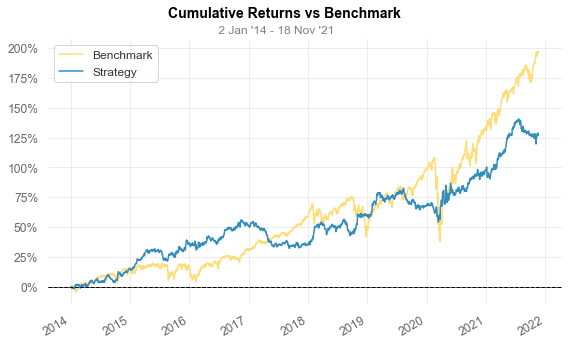

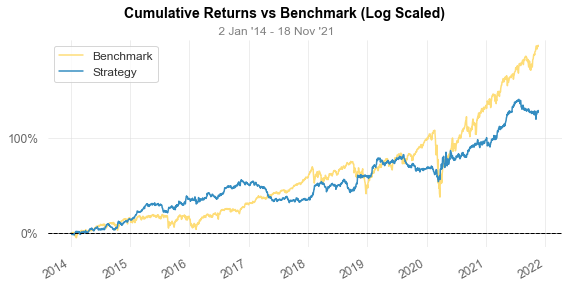

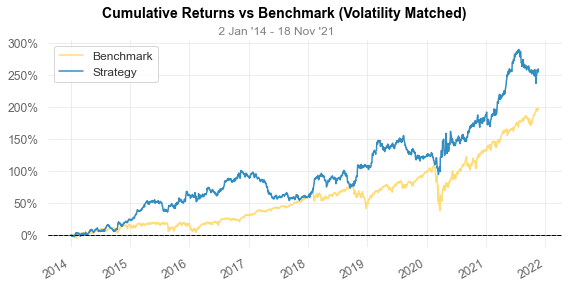

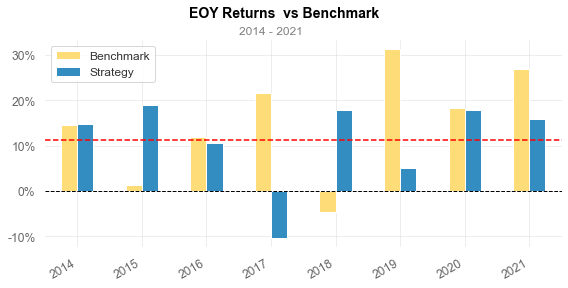

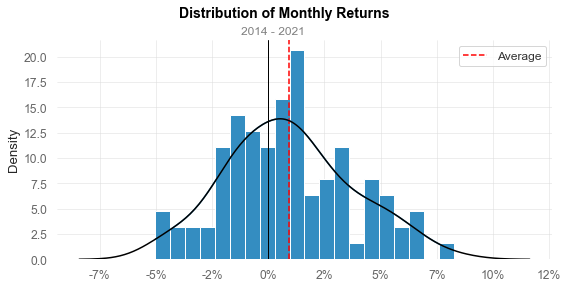

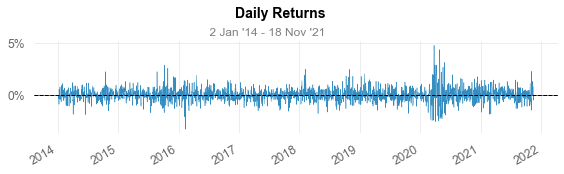

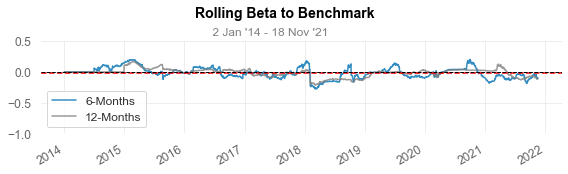

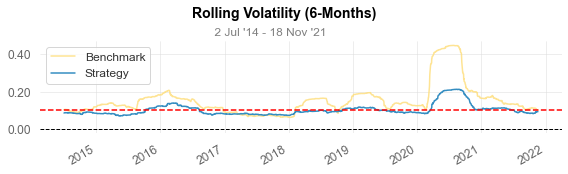

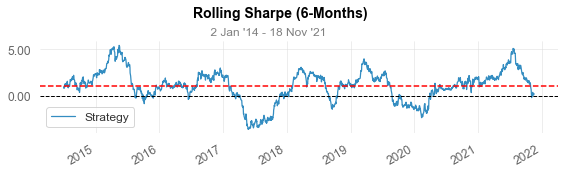

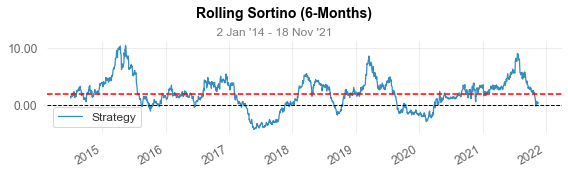

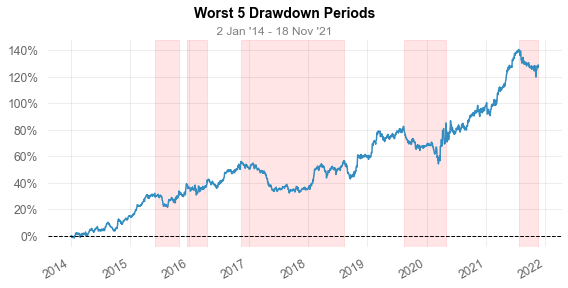

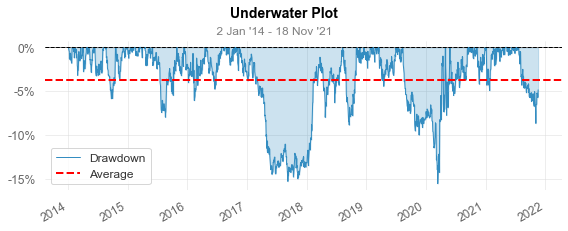

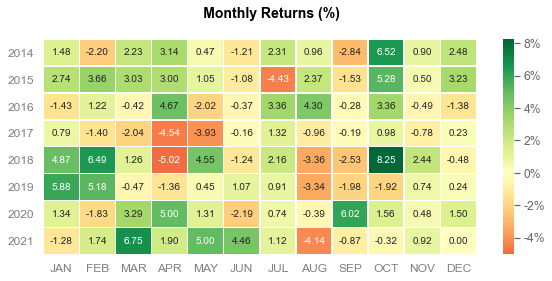

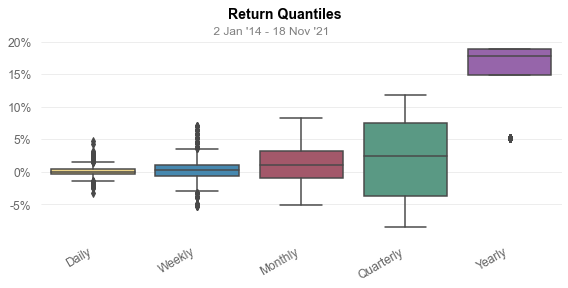

In [29]:
import quantstats as qs
pd.options.display.max_rows = 4000
qs.reports.full(ret *3  , "SPY")

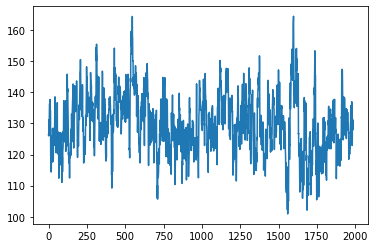

In [17]:
pd.Series(results[0].leverage_l[253:]).plot()